In [83]:
#imports
from datetime import datetime as dt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### Loading Datasets

In [84]:
# file path
file_path="C:/Users/Davie/Desktop/introduction-to-power-bi/"

In [85]:
#load demographic data
demographic=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerDemographic', index_col=False, header=0, usecols="A:M", skiprows=1)

In [86]:
#load customer address
address=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='CustomerAddress', index_col=False, header=0, usecols="A:F", skiprows=1)

In [87]:
#load transaction data
transactions=pd.read_excel(file_path+"KPMG/KPMG_VI_New_raw_data_update_final.xlsx",sheet_name='Transactions', index_col=False, header=0, usecols="A:M", skiprows=1)

### Merging the datasets

In [88]:
#merge demographic data with customer address
demographic_address=pd.merge(demographic, address, on='customer_id', how='inner')

In [89]:
#merged all the 3 datasets
demographic_address_transactions=pd.merge(demographic_address, transactions, on='customer_id', how='inner')

### Data Cleaning

In [90]:
# Drop deceased persons
df=demographic_address_transactions[demographic_address_transactions['deceased_indicator']=='N']

In [91]:
# Drop duplicated customer ids
data=df.dropna(how='any').drop_duplicates(subset=['customer_id'])

### Feature engineering

In [92]:
#calculate product margin
data['product_margin']=(data['list_price']-data['standard_cost'])/data['list_price']

In [93]:

# Calculate age

# convert DOB to datetime
data['DOB']=pd.to_datetime(data['DOB'], errors='coerce')
# Get the current date
current_date = pd.to_datetime('today')

# Now you can safely calculate age
data['age'] = data['DOB'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)) if pd.notnull(x) else None)

In [94]:
# Define age bins and labels
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20','20-30','30-40','40-50','50-60','60-70', '>70']

# Create age groups
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

In [95]:
# Date of transaction
data['transaction_date'] = pd.to_datetime(data['transaction_date'])

# Extract the daya, monthand year from transaction_date
data['trans_day'] = data['transaction_date'].dt.day
data['trans_month'] = data['transaction_date'].dt.month

In [96]:
# Replace values for gender and state in the entire DataFrame
data['gender'] = data['gender'].replace({'Femal': 'Female', 'F': 'Female'})
data['state']=data['state'].replace({'New South Wales':'NSW','Victoria':'VIC'})

In [97]:
# Define tenure ranges
bins = [0, 5, 10, 15, 25]
labels = ['<5','5-10', '10-15', '>15']

# Create age groups
data['tenure_period'] = pd.cut(data['tenure'], bins=bins, labels=labels, right=False)

In [98]:
# Define proterty valuation ranges
bins = [0, 3, 6, 9, 13]
labels = ['<3','3-6', '6-9', '>9']

# Create age groups
data['valuation_category'] = pd.cut(data['property_valuation'], bins=bins, labels=labels, right=False)

### Distribution for Bikes Purchased to be used as the target variable

<Axes: ylabel='Frequency'>

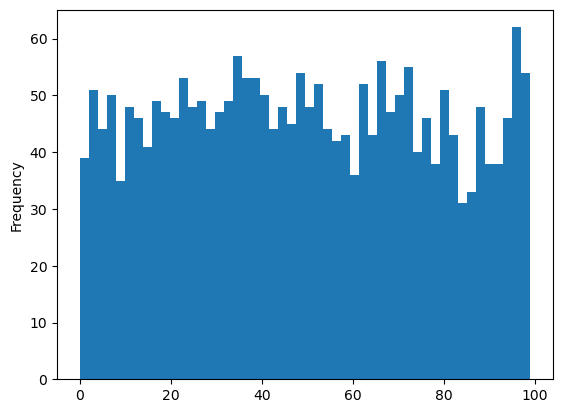

In [99]:
# Histogram
data['past_3_years_bike_related_purchases'].plot.hist(bins=50)

<Axes: >

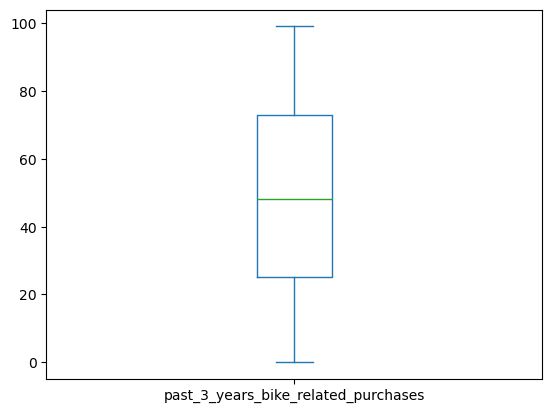

In [100]:
# Box plot
data['past_3_years_bike_related_purchases'].plot.box()

### Columns

In [101]:
# Check new columns
data.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'address', 'postcode', 'state',
       'country', 'property_valuation', 'transaction_id', 'product_id',
       'transaction_date', 'online_order', 'order_status', 'brand',
       'product_line', 'product_class', 'product_size', 'list_price',
       'standard_cost', 'product_first_sold_date', 'product_margin', 'age',
       'age_group', 'trans_day', 'trans_month', 'tenure_period',
       'valuation_category'],
      dtype='object')

In [102]:
# Select columns to use in the Model
cols=['customer_id', 'gender','age_group', 'state', 'job_industry_category', 'job_title','online_order', 'order_status' ,'wealth_segment',  
      'brand','product_line', 'product_class', 'product_size', 'tenure', 'tenure_period', 'past_3_years_bike_related_purchases', 
      'valuation_category', 'property_valuation', 'product_margin']

In [103]:
# Store cleaned data

clean_data=data[cols]
clean_data.to_csv('clean_data.csv', index=False)

In [104]:
# Load the clean dataset

clean_data=pd.read_csv('clean_data.csv')
clean_data.dropna(how='any', inplace=True)

### Encoding, Setting target and feature variables

- Choose the encoding method based on the nature of your data and the requirements of your machine learning model. 
- `One-hot encoding` is suitable when there is no ordinal relationship between categories
- `label encoding` is useful when there is an ordinal relationship between categories. 
- **Example**
    - Label encoding for Ordinal Variables
    - `ordinal_mapping_prod_size = {'small': 0, 'medium': 1, 'large': 2} #product size`
    - `ordinal_data['product_size'] = ordinal_data['product_size'].map(ordinal_mapping_prod_size)`
    - `data.reset_index(drop=True, inplace=True)`  # Reset index of X without adding it as a new column
    - Select categorical columns `categorical_ordinal = ['product_class', 'product_size']`
    - `model_data_class = pd.concat([data_c, encoded_data], axis=1)`
    - Initialize LabelEncoder `label_encoder = LabelEncoder()`
    - Apply Label Encoding to each column `for col in categorical_ordinal:data_clean[col] = label_encoder.fit_transform(data_clean[col])`
- Always remember to handle unknown categories appropriately, especially when using one-hot encoding.

In [105]:
# Make copy of the data
classification_model_data=clean_data.copy()
classification_model_data

,customer_id,gender,age_group,state,job_industry_category,job_title,online_order,order_status,wealth_segment,brand,product_line,product_class,product_size,tenure,tenure_period,past_3_years_bike_related_purchases,valuation_category,property_valuation,product_margin
0,1,Female,>70,NSW,Health,Executive Secretary,0.0,Approved,Mass Customer,OHM Cycles,Standard,medium,medium,11.0,10-15,93,>9,10,0.469210
1,2,Male,40-50,NSW,Financial Services,Administrative Officer,1.0,Approved,Mass Customer,Giant Bicycles,Standard,medium,medium,16.0,>15,81,>9,10,0.319686
2,9,Female,50-60,NSW,Argiculture,Business Systems Development Analyst,0.0,Approved,Affluent Customer,Solex,Standard,medium,large,8.0,5-10,97,>9,12,0.308960
3,12,Male,20-30,QLD,Manufacturing,Nuclear Power Engineer,0.0,Approved,Mass Customer,Giant Bicycles,Standard,medium,large,8.0,5-10,58,3-6,4,0.678676
4,13,Male,60-70,VIC,Financial Services,Developer I,0.0,Approved,High Net Worth,Solex,Standard,medium,medium,8.0,5-10,38,6-9,6,0.493706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,3493,Male,60-70,NSW,Health,Research Assistant I,0.0,Approved,High Net Worth,Giant Bicycles,Standard,medium,large,18.0,>15,30,>9,10,0.598097
2322,3494,Male,20-30,NSW,Argiculture,Account Representative IV,1.0,Approved,High Net Worth,Giant Bicycles,Road,medium,medium,1.0,<5,72,>9,10,0.460913
2323,3495,Female,30-40,NSW,Financial Services,Programmer III,1.0,Approved,High Net Worth,Giant Bicycles,Standard,high,medium,8.0,5-10,57,>9,9,0.400000
2324,3496,Male,30-40,NSW,Manufacturing,Editor,1.0,Approved,Mass Customer,Solex,Standard,medium,medium,19.0,>15,99,>9,9,0.828737


In [106]:
# Creating binary variable from continous variable
#threshold=classification_model_data['past_3_years_bike_related_purchases'].mean()
#classification_model_data['purchase_bikes']=(classification_model_data['past_3_years_bike_related_purchases']>threshold).astype(int)

classification_model_data['purchase_bikes']=classification_model_data['past_3_years_bike_related_purchases'].apply(lambda x: 1 if x>0 else 0)

In [107]:
# Define and the target variable
features_X = classification_model_data.drop(columns=['purchase_bikes', 'past_3_years_bike_related_purchases', 'customer_id'])
target_y = classification_model_data['purchase_bikes']

In [108]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42)

### Preprocessing

In [109]:
# Define categorical columns and numerical columns
categorical_features = ['gender', 'tenure_period','age_group','state', 'job_industry_category','job_title', 
                    'order_status', 'wealth_segment', 'brand', 'product_line', 'valuation_category', 'product_class', 'product_size']
numerical_features = ['product_margin', 'property_valuation', 'tenure'] 

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]) #([], remainder='passthrough')

### Define Pipelines and Train the model

##### (a) Random Forest
- build a model to predict the likelihood of bike purchases based on demographic and product characteristics

In [110]:
# Create a pipeline with RandomForestClassifier
model_ran = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Train the model
model_ran.fit(X_train, y_train)

# Predict on the test set
y_pred = model_ran.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=0))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 99.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.99      1.00      1.00       462

    accuracy                           0.99       466
   macro avg       0.50      0.50      0.50       466
weighted avg       0.98      0.99      0.99       466

Confusion Matrix:
[[  0   4]
 [  0 462]]


In [111]:
# Predict prob for the whole data including training and testing sets
predicted_probabilities=model_ran.predict_proba(features_X)[:,1]

# Add predicted prob to the original dataset
data['predicted_probabilities']=predicted_probabilities

# Set threshold for the targeted customers
threshold=0.9

# Identify customers to the target
target_customers=data[data['predicted_probabilities']>threshold]

# Sort customers by their predicted probabilities
target_customers=target_customers.sort_values(by='customer_id', ascending=True)

target_customers[['customer_id', 'predicted_probabilities']]

,customer_id,predicted_probabilities
0,1,1.00
11,2,0.99
40,9,1.00
52,12,1.00
59,13,1.00
...,...,...
19925,3493,0.99
19931,3494,1.00
19935,3495,0.99
19942,3496,0.98


##### (b) Logistic Regression

- Logistic regression is used for classification tasks, (not regression). 
- Since we want to determine which demographic and product characteristics influences bike purchases or make customer to purchase the bike, logistic regression is appropriate.

In [112]:
# Create a pipeline with LogisticRegression
model_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000,random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42)

# Train the model
model_log.fit(X_train, y_train)

# Predict on the test set
y_pred = model_log.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred)}')

Accuracy: 0.9914163090128756
Precision: 0.9914163090128756
Recall: 1.0
F1 Score: 0.9956896551724138
ROC AUC Score: 0.5


In [113]:
# Predict prob for the whole data including training and testing sets
predicted_probabilities=model_log.predict_proba(features_X)[:,1]

# Add predicted prob to the original dataset
data['predicted_probabilities']=predicted_probabilities

# Set threshold for the targeted customers
threshold=0.9

# Identify customers to the target
target_customers=data[data['predicted_probabilities']>threshold]

# Sort customers by their predicted probabilities
target_customers=target_customers.sort_values(by='customer_id', ascending=True)

target_customers[['customer_id', 'predicted_probabilities', 'gender', 'tenure_period','age_group','state', 'job_industry_category','job_title', 
                    'order_status', 'wealth_segment', 'brand', 'product_line', 'valuation_category', 'product_class', 'product_size', 'product_margin']]

,customer_id,predicted_probabilities,gender,tenure_period,age_group,state,job_industry_category,job_title,order_status,wealth_segment,brand,product_line,valuation_category,product_class,product_size,product_margin
0,1,0.996048,Female,10-15,>70,NSW,Health,Executive Secretary,Approved,Mass Customer,OHM Cycles,Standard,>9,medium,medium,0.469210
11,2,0.994126,Male,>15,40-50,NSW,Financial Services,Administrative Officer,Approved,Mass Customer,Giant Bicycles,Standard,>9,medium,medium,0.319686
40,9,0.995048,Female,5-10,50-60,NSW,Argiculture,Business Systems Development Analyst,Approved,Affluent Customer,Solex,Standard,>9,medium,large,0.308960
52,12,0.973908,Male,5-10,20-30,QLD,Manufacturing,Nuclear Power Engineer,Approved,Mass Customer,Giant Bicycles,Standard,3-6,medium,large,0.678676
59,13,0.987097,Male,5-10,60-70,VIC,Financial Services,Developer I,Approved,High Net Worth,Solex,Standard,6-9,medium,medium,0.493706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19925,3493,0.988595,Male,>15,60-70,NSW,Health,Research Assistant I,Approved,High Net Worth,Giant Bicycles,Standard,>9,medium,large,0.598097
19931,3494,0.995746,Male,<5,20-30,NSW,Argiculture,Account Representative IV,Approved,High Net Worth,Giant Bicycles,Road,>9,medium,medium,0.460913
19935,3495,0.972244,Female,5-10,30-40,NSW,Financial Services,Programmer III,Approved,High Net Worth,Giant Bicycles,Standard,>9,high,medium,0.400000
19942,3496,0.975241,Male,>15,30-40,NSW,Manufacturing,Editor,Approved,Mass Customer,Solex,Standard,>9,medium,medium,0.828737


##### (c) Decission Tree

In [114]:
# Create a pipeline with DecisionTreeClassifier
model_det = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=42)

# Train the model
model_det.fit(X_train, y_train)

# Predict on the test set
y_pred = model_det.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 98.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.99      0.99      0.99       462

    accuracy                           0.98       466
   macro avg       0.50      0.50      0.50       466
weighted avg       0.98      0.98      0.98       466

Confusion Matrix:
[[  0   4]
 [  3 459]]


### STOP

##### LINEAR RGRESSION

In [115]:
'''# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Visualize feature importances (coefficients)
# Get coefficients from the trained model
coefficients = model.named_steps['classifier'].coef_[0]

# Get feature names (numerical + already one-hot encoded features)
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Filter coefficients for positive influence
importance_df = importance_df[importance_df['Coefficient'] > 0]

# Sort the DataFrame by absolute value of coefficients
importance_df = importance_df.reindex(importance_df.Coefficient.abs().sort_values(ascending=False).index)

# Plot the feature importances
plt.figure(figsize=(10, 38))
plt.barh(importance_df['Feature'], importance_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()'''

"# Preprocessing pipeline for numerical data\nnumerical_transformer = StandardScaler()\n\n# Preprocessing pipeline for categorical data\n#categorical_transformer = OneHotEncoder(handle_unknown='ignore')\n\n# Combine preprocessing steps for numerical columns\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', numerical_transformer, numerical_features)\n    ],\n    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)\n)\nmodel = Pipeline(steps=[\n    ('preprocessor', preprocessor),\n    ('classifier', LogisticRegression(random_state=42))\n])\n\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Train the model\nmodel.fit(X_train, y_train)\n\n# Predict on the test set\ny_pred = model.predict(X_test)\n\n# Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nprint(f'Accuracy: {accuracy * 100:.2f}%')\n\nprint('Classificat

### RANDOM FOREST

In [116]:
'''# Visualize feature importances
# Get feature importances from the trained model
feature_importances = model.named_steps['classifier'].feature_importances_

# Get feature names (numerical + already one-hot encoded features)
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 36))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()'''

"# Visualize feature importances\n# Get feature importances from the trained model\nfeature_importances = model.named_steps['classifier'].feature_importances_\n\n# Get feature names (numerical + already one-hot encoded features)\nfeature_names = numerical_features + [col for col in X.columns if col not in numerical_features]\n\n# Create a DataFrame for visualization\nimportance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})\n\n# Sort the DataFrame by importance\nimportance_df = importance_df.sort_values(by='Importance', ascending=False)\n\n# Plot the feature importances\nplt.figure(figsize=(10, 36))\nplt.barh(importance_df['Feature'], importance_df['Importance'])\nplt.xlabel('Feature Importance')\nplt.ylabel('Feature')\nplt.title('Feature Importances in Random Forest Classifier')\nplt.gca().invert_yaxis()\nplt.show()"

##### DECISSION TREE

In [117]:
'''# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)
)



# Visualize feature importances
# Get feature importances from the trained model
feature_importances = model.named_steps['classifier'].feature_importances_

# Get feature names (numerical + already one-hot encoded features)
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 38))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree Classifier')
plt.gca().invert_yaxis()
plt.show()'''

"# Preprocessing pipeline for numerical data\nnumerical_transformer = StandardScaler()\n\n# Preprocessing pipeline for categorical data\n#categorical_transformer = OneHotEncoder(handle_unknown='ignore')\n\n# Combine preprocessing steps for numerical columns\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', numerical_transformer, numerical_features)\n    ],\n    remainder='passthrough'  # Keep all other columns as they are (already preprocessed/one-hot encoded)\n)\n\n\n\n# Visualize feature importances\n# Get feature importances from the trained model\nfeature_importances = model.named_steps['classifier'].feature_importances_\n\n# Get feature names (numerical + already one-hot encoded features)\nfeature_names = numerical_features + [col for col in X.columns if col not in numerical_features]\n\n# Create a DataFrame for visualization\nimportance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})\n\n# Sort the DataFrame by importance\nimp

##### LOGISTIC REGRESSION


In [118]:
'''# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Combine preprocessing steps for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'  # Keep all other columns as they already preprocessed/one-hot encoded
)'''



"# Preprocessing pipeline for numerical data\nnumerical_transformer = StandardScaler()\n\n# Combine preprocessing steps for numerical columns\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', numerical_transformer, numerical_features)\n    ],\n    remainder='passthrough'  # Keep all other columns as they already preprocessed/one-hot encoded\n)"

In [119]:
'''# Interpret the model coefficients

# Get the feature names after one-hot encoding and scaling
feature_names = numerical_features + [col for col in X.columns if col not in numerical_features]

# Get the coefficients from the logistic regression model
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of the coefficient to see the most influential features
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

#coef_df.to_csv('coj.csv',index=False)

print(coef_df)'''

"# Interpret the model coefficients\n\n# Get the feature names after one-hot encoding and scaling\nfeature_names = numerical_features + [col for col in X.columns if col not in numerical_features]\n\n# Get the coefficients from the logistic regression model\ncoefficients = model.named_steps['classifier'].coef_[0]\n\n# Create a DataFrame for the coefficients\ncoef_df = pd.DataFrame({\n    'Feature': feature_names,\n    'Coefficient': coefficients\n})\n\n# Sort by absolute value of the coefficient to see the most influential features\ncoef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()\ncoef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)\n\n#coef_df.to_csv('coj.csv',index=False)\n\nprint(coef_df)"

In [120]:
'''# Filter coefficients for negative contribution to bike purchases
negative_coef_df = coef_df[coef_df['Coefficient'] < 0]

# Sort coefficients in ascending order (from most negative to least negative)
negative_coef_df = negative_coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients for negative contribution to bike purchases
plt.figure(figsize=(10, 36))
plt.barh(negative_coef_df['Feature'], negative_coef_df['Coefficient'], color='salmon')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Negative Contribution to Bike Purchases (Most Negative to Least Negative)')
plt.grid(axis='x')
plt.show()'''

"# Filter coefficients for negative contribution to bike purchases\nnegative_coef_df = coef_df[coef_df['Coefficient'] < 0]\n\n# Sort coefficients in ascending order (from most negative to least negative)\nnegative_coef_df = negative_coef_df.sort_values(by='Coefficient', ascending=False)\n\n# Plot the coefficients for negative contribution to bike purchases\nplt.figure(figsize=(10, 36))\nplt.barh(negative_coef_df['Feature'], negative_coef_df['Coefficient'], color='salmon')\nplt.xlabel('Coefficient')\nplt.title('Logistic Regression Coefficients for Negative Contribution to Bike Purchases (Most Negative to Least Negative)')\nplt.grid(axis='x')\nplt.show()"

In [121]:
'''# Filter coefficients for positive influence
positive_coef_df = coef_df[coef_df['Coefficient'] > 0]

# Sort coefficients in descending order
positive_coef_df = positive_coef_df.sort_values(by='Coefficient', ascending=True)

# Plot the coefficients for positive influence
plt.figure(figsize=(10, 36))
plt.barh(positive_coef_df['Feature'], positive_coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Logistic Regression Coefficients for Positive Influence')
plt.grid(axis='x')
plt.show()'''

"# Filter coefficients for positive influence\npositive_coef_df = coef_df[coef_df['Coefficient'] > 0]\n\n# Sort coefficients in descending order\npositive_coef_df = positive_coef_df.sort_values(by='Coefficient', ascending=True)\n\n# Plot the coefficients for positive influence\nplt.figure(figsize=(10, 36))\nplt.barh(positive_coef_df['Feature'], positive_coef_df['Coefficient'], color='skyblue')\nplt.xlabel('Coefficient')\nplt.title('Logistic Regression Coefficients for Positive Influence')\nplt.grid(axis='x')\nplt.show()"

### REGRESSION

In [122]:
# make copy
reg_data_model=clean_data.copy()
reg_data_model

,customer_id,gender,age_group,state,job_industry_category,job_title,online_order,order_status,wealth_segment,brand,product_line,product_class,product_size,tenure,tenure_period,past_3_years_bike_related_purchases,valuation_category,property_valuation,product_margin
0,1,Female,>70,NSW,Health,Executive Secretary,0.0,Approved,Mass Customer,OHM Cycles,Standard,medium,medium,11.0,10-15,93,>9,10,0.469210
1,2,Male,40-50,NSW,Financial Services,Administrative Officer,1.0,Approved,Mass Customer,Giant Bicycles,Standard,medium,medium,16.0,>15,81,>9,10,0.319686
2,9,Female,50-60,NSW,Argiculture,Business Systems Development Analyst,0.0,Approved,Affluent Customer,Solex,Standard,medium,large,8.0,5-10,97,>9,12,0.308960
3,12,Male,20-30,QLD,Manufacturing,Nuclear Power Engineer,0.0,Approved,Mass Customer,Giant Bicycles,Standard,medium,large,8.0,5-10,58,3-6,4,0.678676
4,13,Male,60-70,VIC,Financial Services,Developer I,0.0,Approved,High Net Worth,Solex,Standard,medium,medium,8.0,5-10,38,6-9,6,0.493706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,3493,Male,60-70,NSW,Health,Research Assistant I,0.0,Approved,High Net Worth,Giant Bicycles,Standard,medium,large,18.0,>15,30,>9,10,0.598097
2322,3494,Male,20-30,NSW,Argiculture,Account Representative IV,1.0,Approved,High Net Worth,Giant Bicycles,Road,medium,medium,1.0,<5,72,>9,10,0.460913
2323,3495,Female,30-40,NSW,Financial Services,Programmer III,1.0,Approved,High Net Worth,Giant Bicycles,Standard,high,medium,8.0,5-10,57,>9,9,0.400000
2324,3496,Male,30-40,NSW,Manufacturing,Editor,1.0,Approved,Mass Customer,Solex,Standard,medium,medium,19.0,>15,99,>9,9,0.828737


In [130]:
# Define numerical and categorical features
numerical_features = ['product_margin'] # 'property_valuation', 'tenure'
categorical_features = ['customer_id','gender','age_group','state','job_industry_category','job_title','online_order','order_status','wealth_segment','brand','product_line','product_class','product_size','tenure_period','valuation_category']

'''[col for col in reg_data_model.columns if col != 'past_3_years_bike_related_purchases' 
                        and col != 'product_margin'
                        and col !='tenure'
                        and col !='property_valuation']'''

"[col for col in reg_data_model.columns if col != 'past_3_years_bike_related_purchases' \n                        and col != 'product_margin'\n                        and col !='tenure'\n                        and col !='property_valuation']"

In [131]:
# Select relevant features and the target variable
X = reg_data_model.drop(columns=['past_3_years_bike_related_purchases',  'property_valuation', 'tenure'])
y = reg_data_model['past_3_years_bike_related_purchases']

MAE: 24.951654785213
MSE: 881.0176727742933
RMSE: 29.68194186326584
R-squared: -0.10752775408418969


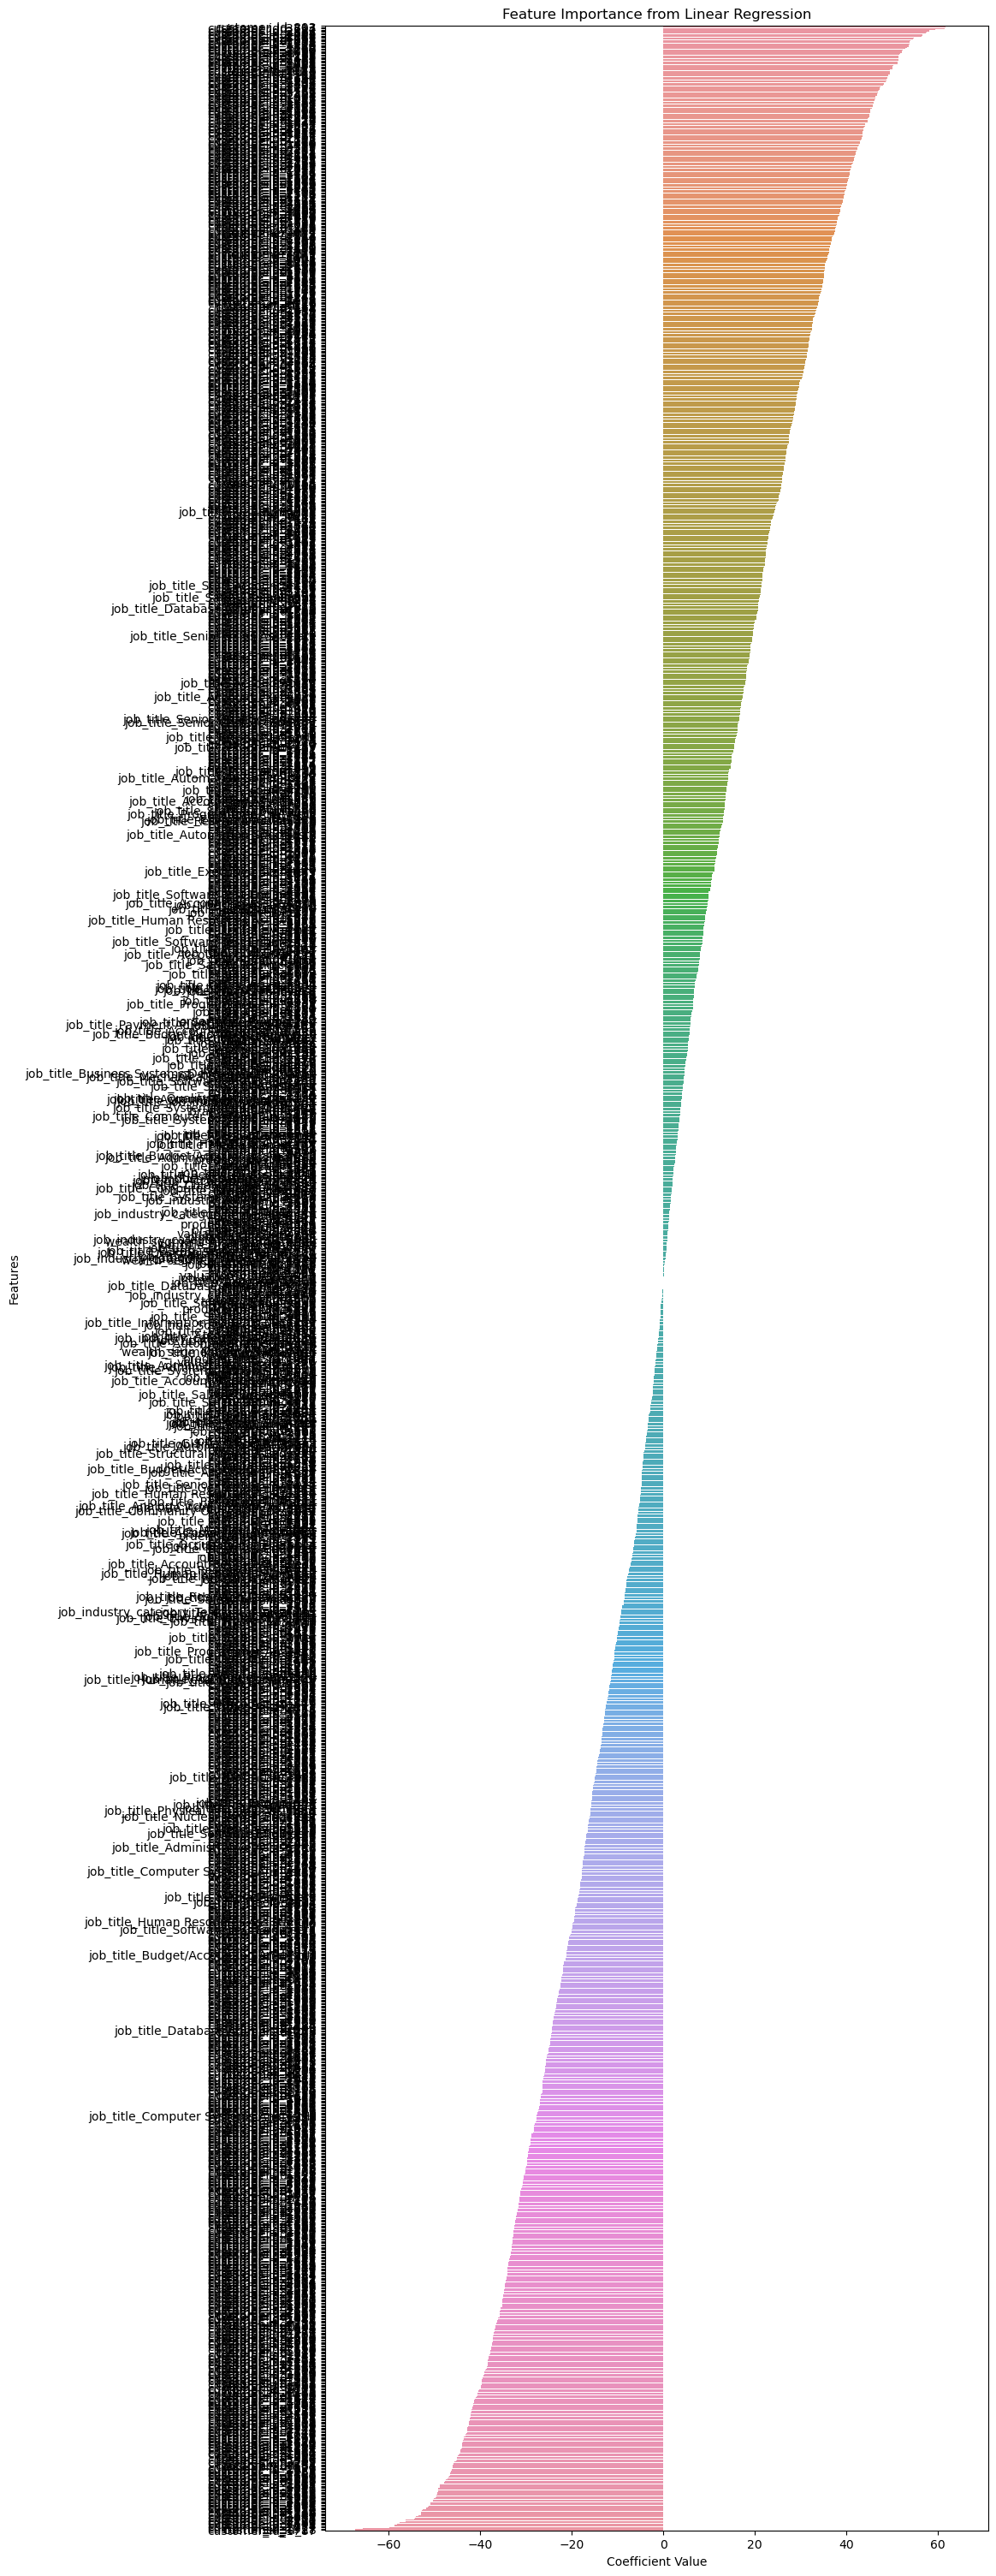

In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Preprocessing pipeline for numerical data
numerical_transformer = StandardScaler()

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps for specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Feature importance
# Get the feature names from the preprocessor
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
all_features = num_features + cat_features.tolist()

# Get the coefficients
coefficients = model.named_steps['regressor'].coef_

# Create a DataFrame for visualization
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 38))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Importance from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

- Use RandomForestRegressor when your target variable is a continuous value that you need to predict.
- Use RandomForestClassifier when your target variable is a categorical label or class.

In [133]:
# make copy
ran_data_model=data.copy()

In [127]:
# Define numerical and categorical features
#numerical_features = ['product_margin'] 
#categorical_features = [col for col in ran_data_model.columns if col != 'past_3_years_bike_related_purchases' and col != 'product_margin']

In [134]:
# Select relevant features and the target variable
X = ran_data_model.drop(columns=['past_3_years_bike_related_purchases',  'property_valuation', 'tenure'])
y = ran_data_model['past_3_years_bike_related_purchases']

R-squared: -0.07445875412751057


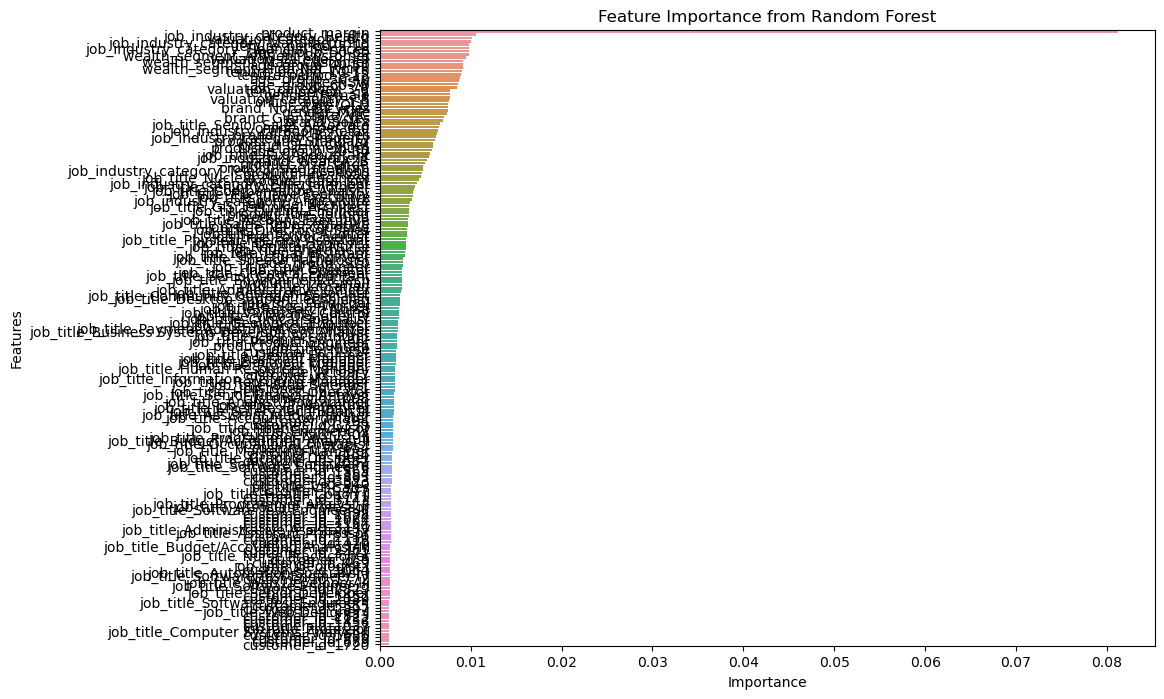

In [135]:
# Preprocess data: one-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
r_squared = model.score(X_test, y_test)
print(f'R-squared: {r_squared}')

# Feature importance
# Get the feature names from the preprocessor
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
all_features = num_features + cat_features.tolist()

# Get the feature importances
importances = model.named_steps['regressor'].feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})

# Set a threshold for feature importance
threshold = 0.001

# Filter features based on the threshold
important_features_df = importance_df[importance_df['Importance'] >= threshold]

# Sort the important features by their importance
important_features_df = important_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=important_features_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()